In [1]:
from sklearn.model_selection import KFold
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools

# ---- Load and Preprocess Data ----
train_dir = 'D:/Lung_cancer/train'  # Training directory path
target_size = (299, 299)  # Input size for InceptionV3
num_classes = 3

# Extract file paths and labels
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,  # Temporary batch size
    class_mode='categorical',
    shuffle=False  # To keep track of indices
)
X = np.array(train_generator.filepaths)  # File paths of images
y = np.array(train_generator.classes)    # Corresponding class labels

# ---- Hyperparameter Search Space ----
batch_sizes = [16, 32, 64]
dropout_rates = [0.3, 0.5]
learning_rates = [0.0005, 0.001]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_params = {}
best_accuracy = 0

# Iterate over all combinations of hyperparameters
for batch_size, dropout_rate, learning_rate in itertools.product(batch_sizes, dropout_rates, learning_rates):
    print(f"Testing batch_size={batch_size}, dropout={dropout_rate}, lr={learning_rate}")
    
    fold_accuracies = []
    fold_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}")
        
        # Split into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Load data dynamically
        def load_data(file_paths, labels):
            images = []
            for file in file_paths:
                img = load_img(file, target_size=target_size)
                img = img_to_array(img)
                images.append(img)
            images = np.array(images) / 255.0
            labels = np.eye(num_classes)[labels]
            return images, labels
        
        X_train_images, y_train_labels = load_data(X_train, y_train)
        X_val_images, y_val_labels = load_data(X_val, y_val)
        
        # ---- Define and Compile Model ----
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
        base_model.trainable = False
        
        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        output = layers.Dense(num_classes, activation='softmax')(x)
        model = models.Model(inputs=base_model.input, outputs=output)
        
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # ---- Train Model ----
        history = model.fit(
            X_train_images, y_train_labels,
            validation_data=(X_val_images, y_val_labels),
            epochs=10,
            batch_size=batch_size,
            verbose=1
        )
        
        # ---- Evaluate Model ----
        val_loss, val_accuracy = model.evaluate(X_val_images, y_val_labels, verbose=0)
        print(f"Fold {fold + 1} Accuracy: {val_accuracy * 100:.2f}%")
        print(f"Fold {fold + 1} Loss: {val_loss:.4f}")
        
        fold_accuracies.append(val_accuracy)
        fold_losses.append(val_loss)
    
    # Compute mean accuracy for the current hyperparameter combination
    mean_accuracy = np.mean(fold_accuracies)
    mean_loss = np.mean(fold_losses)
    
    print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%, Mean Loss: {mean_loss:.4f}\n")
    
    # Store best hyperparameters
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = {
            "batch_size": batch_size,
            "dropout": dropout_rate,
            "learning_rate": learning_rate,
            "accuracy": best_accuracy
        }

# ---- Final Best Parameters ----
print("Best Parameters:")
print(best_params)

Found 406 images belonging to 3 classes.
Testing batch_size=16, dropout=0.3, lr=0.0005

Fold 1
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4446 - loss: 1.3472 - val_accuracy: 0.7317 - val_loss: 0.5889
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 964ms/step - accuracy: 0.7538 - loss: 0.6271 - val_accuracy: 0.7805 - val_loss: 0.5519
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 942ms/step - accuracy: 0.8071 - loss: 0.4887 - val_accuracy: 0.8171 - val_loss: 0.4587
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 948ms/step - accuracy: 0.8839 - loss: 0.3464 - val_accuracy: 0.8171 - val_loss: 0.4118
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 962ms/step - accuracy: 0.8795 - loss: 0.3324 - val_accuracy: 0.8415 - val_loss: 0.4024
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 984ms/step - accuracy: 0.9095 - loss: 0.2612 - val_accuracy: 0.8293 - val_loss: 0.3640
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 983ms/step - accuracy: 0.9227 - loss: 0.2248 - val_accuracy: 0.8171 - val_loss: 0.4005
Epoch

In [ ]:
batch_size = 16
dropout_rate = 0.3
learning_rate = 0.001
epoch = 20

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


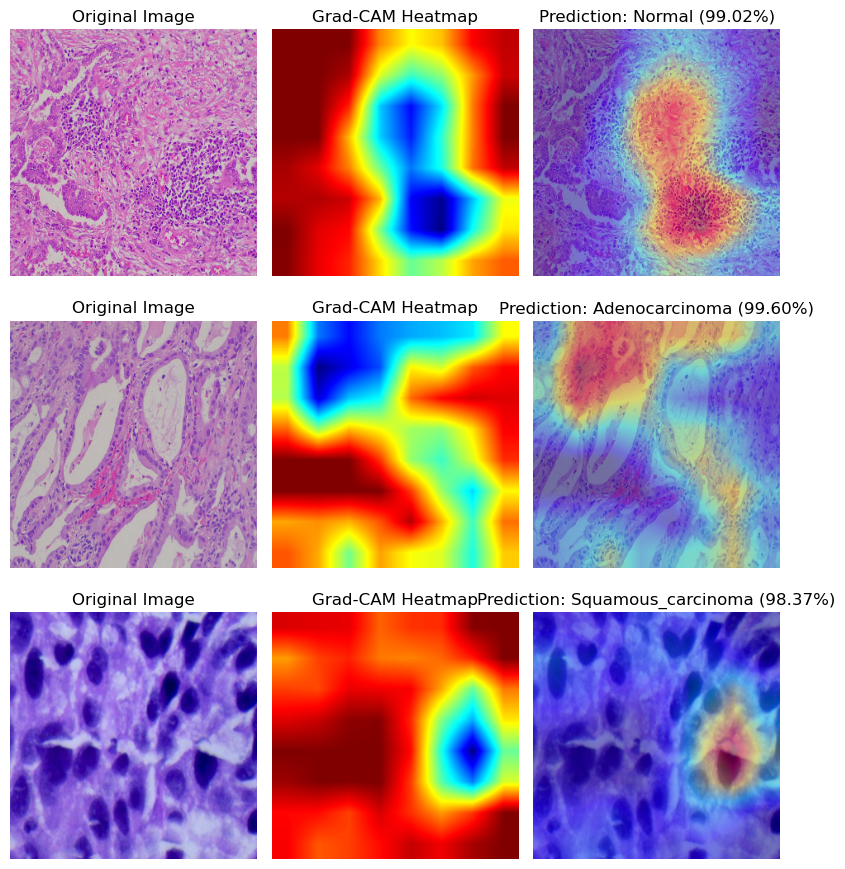


🔥 **Grad-CAM Color Explanation**:
- **🔴 Red Areas** → Most critical for classification (high activation)
- **🟠 Orange/Yellow Areas** → Moderately important
- **🟢 Green/Blue Areas** → Less relevant



In [48]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ---- Load trained model ----
model_path = "inceptionV3_lungcancer_best_model.keras"
model = tf.keras.models.load_model(model_path)

# ---- Define class labels ----
class_labels = ['Adenocarcinoma', 'Normal', 'Squamous_carcinoma']

# ---- Grad-CAM Color Descriptions ----
color_description = """
🔥 **Grad-CAM Color Explanation**:
- **🔴 Red Areas** → Most critical for classification (high activation)
- **🟠 Orange/Yellow Areas** → Moderately important
- **🟢 Green/Blue Areas** → Less relevant
"""

# ---- List of image paths ----
image_paths = [
    r"D:\Lung_cancer\train\Nor\nor_20x_37.jpg",
    r"D:\Lung_cancer\train\Adenocarcinoma\aca_bd_20x_15.jpg",
    r"D:\Lung_cancer\LC25000_sampled\Squamous_carcinoma\lungscc51.jpeg"
]

# ---- Grad-CAM Implementation ----
def generate_grad_cam(image_path, model, layer_name="mixed10"):  # 'mixed10' is a common last conv layer in InceptionV3
    """ Generate Grad-CAM heatmap for an image """
    
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get model prediction
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_index]
    confidence = np.max(predictions) * 100

    # Grad-CAM logic
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, predicted_index]

    # Get gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    # Multiply each channel by the pooled gradients
    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Create heatmap
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Load original image with OpenCV
    original_img = cv2.imread(image_path)
    original_img = cv2.resize(original_img, (299, 299))
    heatmap = cv2.resize(heatmap, (299, 299))

    # Convert heatmap to RGB using OpenCV
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    return original_img, heatmap, superimposed_img, predicted_class_name, confidence

# ---- Process and Display Images ----
num_images = len(image_paths)
plt.figure(figsize=(8,3  * num_images))

for i, img_path in enumerate(image_paths):
    original, heatmap, superimposed, pred_class, conf = generate_grad_cam(img_path, model)

    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {pred_class} ({conf:.2f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()
# ---- Print Color Explanation ----
print(color_description)